In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt

2023-04-20 00:12:37.552008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):     
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(aLine.removeprefix("__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(aLine.removeprefix("__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [4]:
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = layers.experimental.preprocessing.TextVectorization(max_tokens = maxFeatures, 
    standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int', 
    output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [31]:
x_train, y_train, seqLength = readData("data/amazon/train_small.txt")
x_test, y_test, tmp = readData("data/amazon/test_small.txt")

#maxFeatures is a hyperparameter
maxFeatures = 15000

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, 
maxFeatures, seqLength)

# Dataset
Now we check the distribution of the classes, in order to know if we need to apply any balancing techniques. We will not delve into the language difference, as the solution to it isn't very clear. 
- We could detect and translate the minority language to the majority one, that way the model would have more samples of the same language anmd thus would learn better, but that would remove its capability of understanding the minority language.
- We could also translate all text to both languages, increasing the overall samples of each language, thus improving the model, but this would imply using pre-existing language models to identify the samples' language and translate it, thus kinda defeating the purpose of this practical assignment.

Number of training examples for label 0:  12117
Number of training examples for label 1:  12883
Number of test examples for label 0:  12157
Number of test examples for label 1:  12843


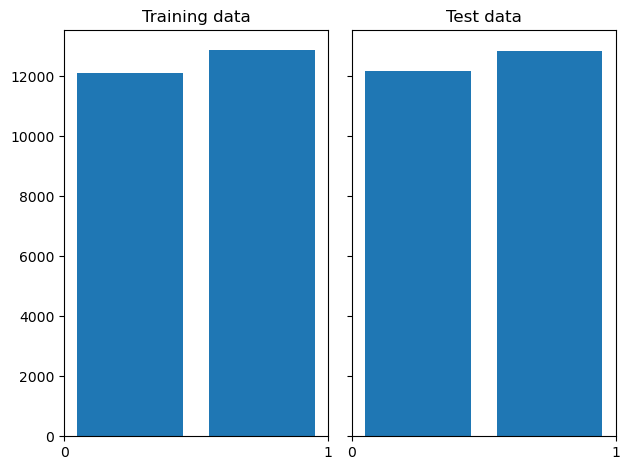

In [6]:
# Create a plot that contains two subplots, one for the distribution of labels of the training data and one for the test data
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# Plot the distribution of labels of the training data
axs[0].hist(y_train, bins=2, rwidth=0.8)
# Add a title to the first subplot
axs[0].set_title('Training data')
# Label the x-axis of the first subplot with each label
axs[0].set_xticks([0, 1])

# Plot the distribution of labels of the test data
axs[1].hist(y_test, bins=2, rwidth=0.8)
# Add a title to the second subplot
axs[1].set_title('Test data')
# Label the x-axis of the first subplot with each label
axs[1].set_xticks([0, 1])

# Print the number of training examples and the number of test examples for each label
print("Number of training examples for label 0: ", np.sum(y_train == 0))
print("Number of training examples for label 1: ", np.sum(y_train == 1))
print("Number of test examples for label 0: ", np.sum(y_test == 0))
print("Number of test examples for label 1: ", np.sum(y_test == 1))

As shown by the plots, there is no need to perform any dataset balancing, as the labels are divided almost evenly

# Architecture

As proven in the previous practical assignment, Bidirectional LSTMs were the best performing architecture, so even though this is a compeltely different problem, they give us an indication on which model to try first.

We used a dropout of 0.6 as to decrease the severe overfitting that the network suffers, as lesser dropout values weren't enough. Dimensionalities higher than 20 were producing slightly worse results, as well as drastically increasing the training time, so we settled for 20. The Embedding layer learned well enough with a dimensionality of 40, and the base sequence length was well suited, larger values would insert too much padding in the shorter phrases.

We've tried relu as well as sigmoid for the activation functions, but sigmoid was slightly better. Same with the optimizers, we tested adam and rmsprop, of which rmsprop was slightly better.

In [28]:
model = Sequential()

model.add(layers.Embedding(maxFeatures, 40, input_length=seqLength))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))

model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 166, 40)           200000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 41        
                                                                 
Total params: 209,801
Trainable params: 209,801
Non-trainable params: 0
_________________________________________________________________


In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint("modelsAmazon/bidirectionallstm.keras", monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

history = model.fit(x_train_int, y_train, epochs=70,validation_data=(x_test_int, y_test),callbacks=callbacks)

Epoch 1/70
782/782 [==============================] - 195s 246ms/step - loss: 0.4381 - accuracy: 0.7901 - val_loss: 0.3092 - val_accuracy: 0.8714
Epoch 2/70
782/782 [==============================] - 208s 266ms/step - loss: 0.2805 - accuracy: 0.8852 - val_loss: 0.3341 - val_accuracy: 0.8696
Epoch 3/70
782/782 [==============================] - 216s 276ms/step - loss: 0.2522 - accuracy: 0.8995 - val_loss: 0.3407 - val_accuracy: 0.8636
Epoch 4/70
782/782 [==============================] - 206s 264ms/step - loss: 0.2365 - accuracy: 0.9074 - val_loss: 0.2859 - val_accuracy: 0.8860
Epoch 5/70
782/782 [==============================] - 202s 258ms/step - loss: 0.2289 - accuracy: 0.9116 - val_loss: 0.2817 - val_accuracy: 0.8886
Epoch 6/70
782/782 [==============================] - 204s 261ms/step - loss: 0.2220 - accuracy: 0.9142 - val_loss: 0.2694 - val_accuracy: 0.8928
Epoch 7/70
782/782 [==============================] - 205s 262ms/step - loss: 0.2157 - accuracy: 0.9176 - val_loss: 0.2739 -

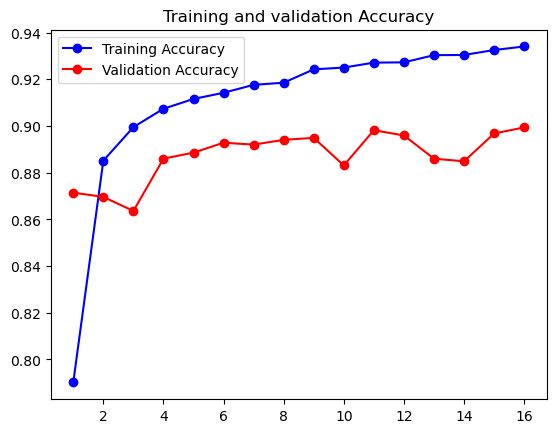

Highers validation accuracy:  0.899399995803833


In [30]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training Accuracy")
plt.plot(epochs, val_loss, "r-o", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

print("Highers validation accuracy: ", max(val_loss))

# Results
For the parameter maxFeatures, we've tried a value of 10000, which gave us 89.57% of accuracy, but after just 11 epochs, the model stopped improving, and it started to overfit. We changed the value to 5000, as well as adding early stopping with 5 epochs of patience. This time we've achieved an 89.93% of accuracy, stopping at 16 epochs (epoch 11 yielded the best results).

Compared to the assignment's benchmark accuracy (84%), we improved it by almost 6%, with a relatively fast to train model. In order to try out a more exhaustive search of the optimal parameters, a grid search could be performed, testing all combinations of possible values for the parameters.

# Bidirectional2

In [32]:
model = Sequential()

model.add(layers.Embedding(maxFeatures, 40, input_length=seqLength))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))

model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 166, 40)           600000    
                                                                 
 bidirectional_9 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                 
Total params: 609,801
Trainable params: 609,801
Non-trainable params: 0
_________________________________________________________________


In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint("modelsAmazon/bidirectionallstm.keras", monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

history = model.fit(x_train_int, y_train, epochs=50,validation_data=(x_test_int, y_test),callbacks=callbacks)

Epoch 1/50
782/782 [==============================] - 344s 406ms/step - loss: 0.4070 - accuracy: 0.8091 - val_loss: 0.3050 - val_accuracy: 0.8755
Epoch 2/50
782/782 [==============================] - 323s 413ms/step - loss: 0.2310 - accuracy: 0.9100 - val_loss: 0.2740 - val_accuracy: 0.8894
Epoch 3/50
782/782 [==============================] - 276s 353ms/step - loss: 0.1786 - accuracy: 0.9341 - val_loss: 0.2999 - val_accuracy: 0.8858
Epoch 4/50
782/782 [==============================] - 237s 303ms/step - loss: 0.1467 - accuracy: 0.9464 - val_loss: 0.2978 - val_accuracy: 0.8834
Epoch 5/50
782/782 [==============================] - 236s 302ms/step - loss: 0.1283 - accuracy: 0.9538 - val_loss: 0.3887 - val_accuracy: 0.8757
Epoch 6/50
782/782 [==============================] - 219s 280ms/step - loss: 0.1099 - accuracy: 0.9606 - val_loss: 0.3860 - val_accuracy: 0.8700
Epoch 7/50
782/782 [==============================] - 216s 276ms/step - loss: 0.0963 - accuracy: 0.9650 - val_loss: 0.4128 -

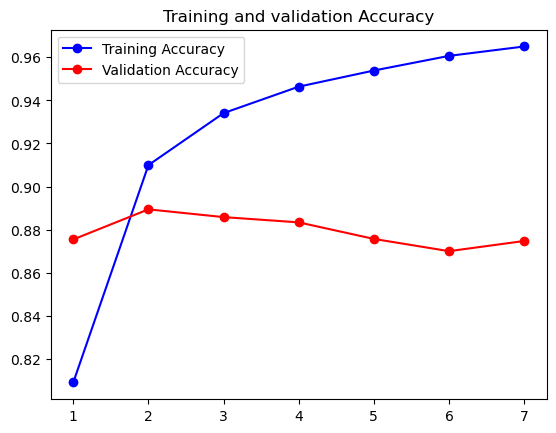

Highers validation accuracy:  0.8894400000572205


In [34]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training Accuracy")
plt.plot(epochs, val_loss, "r-o", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

print("Highers validation accuracy: ", max(val_loss))